In [1]:
# Standard Library
import argparse
from time import perf_counter

# Third Party Library
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
import optuna
import pandas as pd
from egraph import Drawing, all_sources_bfs
from ex_utils.config.dataset import dataset_names
from ex_utils.config.paths import get_dataset_path
from ex_utils.config.quality_metrics import qm_names, qm_name_abbreviations
from ex_utils.share import (
    draw,
    draw_and_measure,
    ex_path,
    generate_base_df_data,
    generate_seed_median_df
)
from ex_utils.utils.graph import (
    egraph_graph,
    load_nx_graph,
    nx_graph_preprocessing,
)
from tqdm import tqdm
import plotly.graph_objects as go
from statistics import mean, stdev
from sklearn.preprocessing import StandardScaler

/Users/fuga_takata/dev/vdslab-project/hyperparameter-in-graph-drawing/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'sample_size': 1000, 'mean_angular_resolution': -1008.7414409790039, 'std_angular_resolution': 60.76385015420233, 'mean_aspect_ratio': 0.7826731505990029, 'std_aspect_ratio': 0.10317142254451431, 'mean_crossing_angle': -0.400271653305296, 'std_crossing_angle': 0.008494652299983495, 'mean_crossing_number': -2330.422, 'std_crossing_number': 596.0088224451316, 'mean_gabriel_graph_property': -90740.5565, 'std_gabriel_graph_property': 123151.9232173301, 'mean_ideal_edge_length': -44.46626843643188, 'std_ideal_edge_length': 44.86792561316209, 'mean_neighborhood_preservation': 0.31451279382407665, 'std_neighborhood_preservation': 0.10230389273775327, 'mean_node_resolution': -22273.578905273436, 'std_node_resolution': 4116.856001074087, 'mean_stress': -443.36938243865967, 'std_stress': 171.69475522951134, 'mean_time_complexity': -197687.94829812358, 'std_time_complexity': 257575.20826702032}


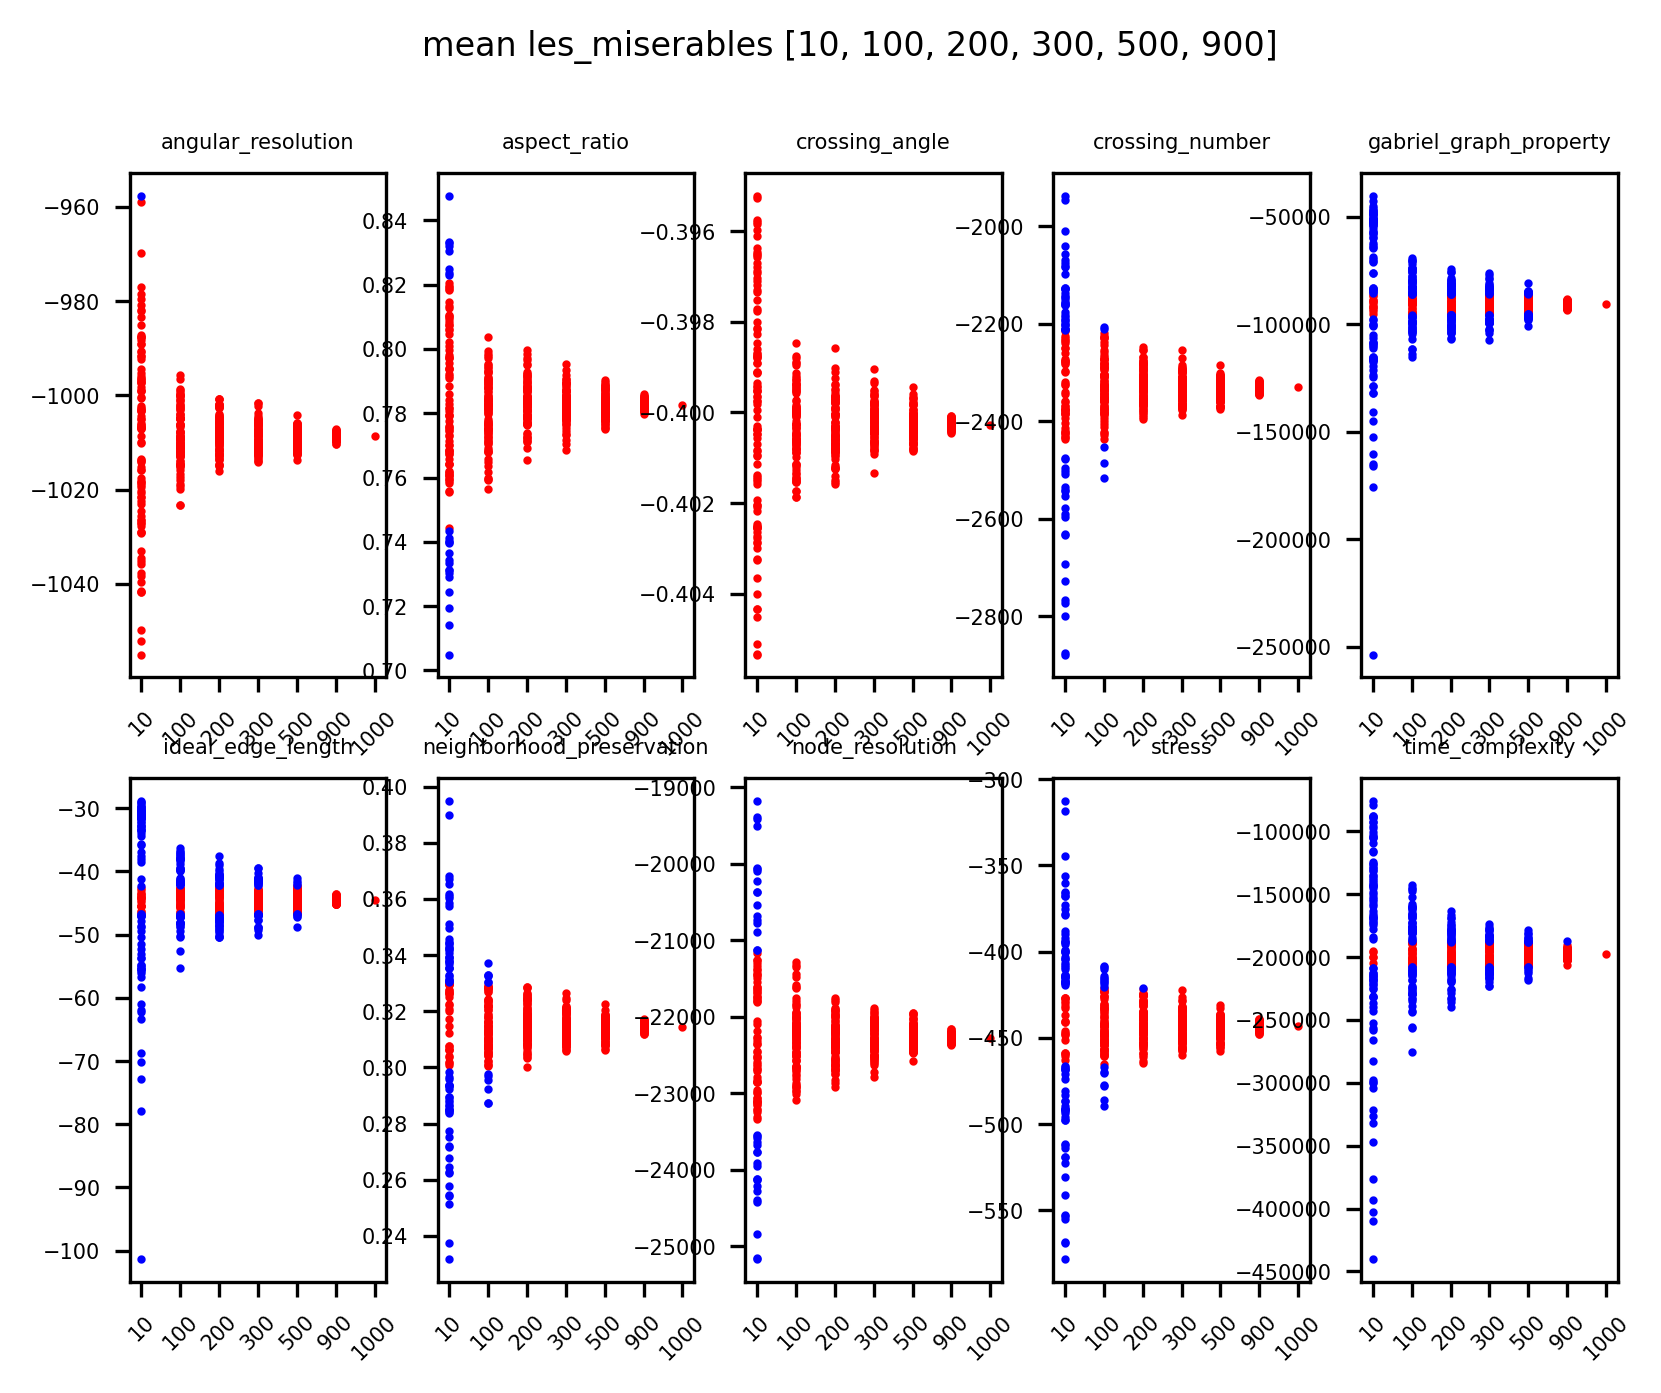

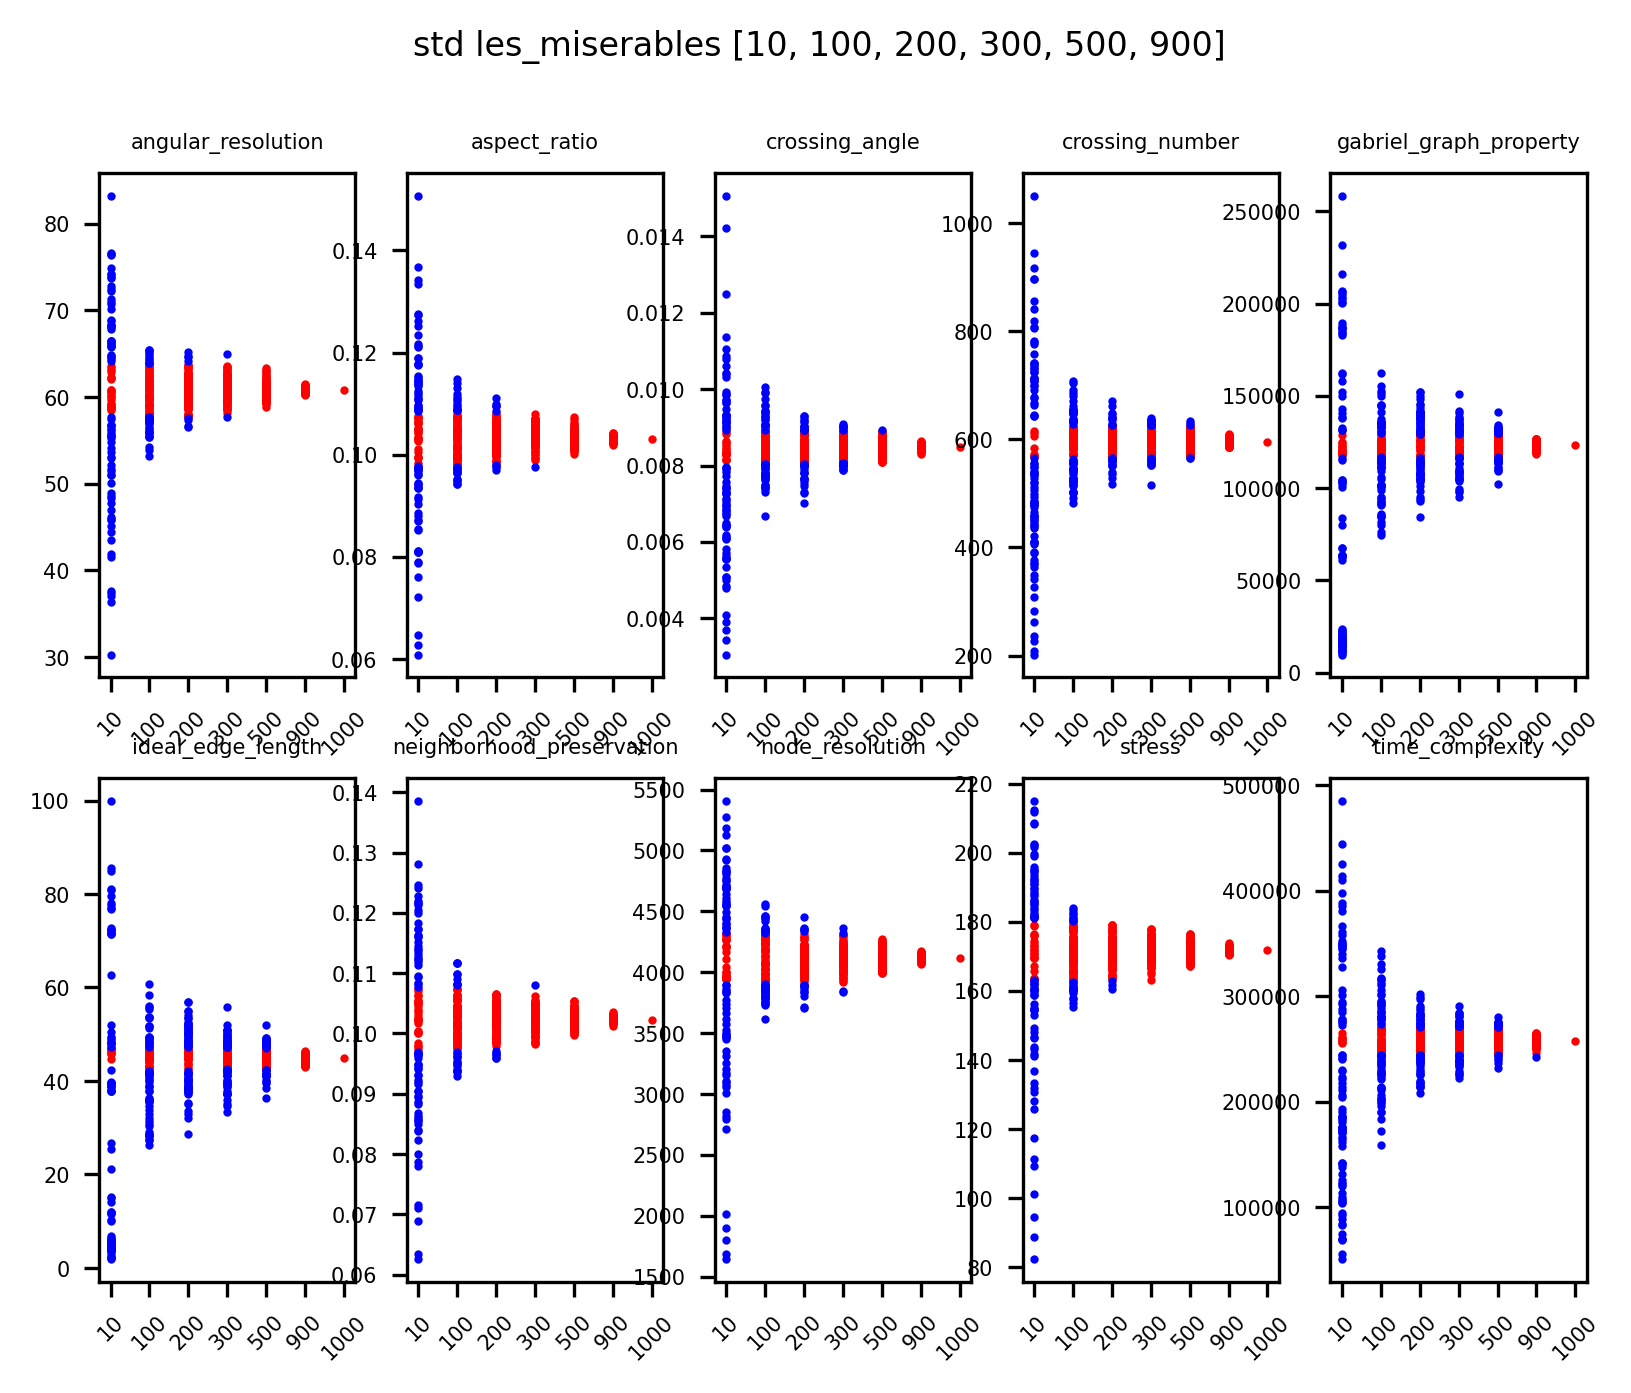

{'sample_size': 1000, 'mean_angular_resolution': -1336.8688468017579, 'std_angular_resolution': 154.53536369844144, 'mean_aspect_ratio': 0.7561193621456623, 'std_aspect_ratio': 0.06126758357083792, 'mean_crossing_angle': -0.49861956892035075, 'std_crossing_angle': 0.05458220334292319, 'mean_crossing_number': -7871.005, 'std_crossing_number': 12081.123476686014, 'mean_gabriel_graph_property': -75770175.38826562, 'std_gabriel_graph_property': 253923558.88770652, 'mean_ideal_edge_length': -5047.835695906639, 'std_ideal_edge_length': 14626.89521896205, 'mean_neighborhood_preservation': 0.06724936083657668, 'std_neighborhood_preservation': 0.03433765512973737, 'mean_node_resolution': -84051541.664, 'std_node_resolution': 17600373.464896534, 'mean_stress': -84368.87402734374, 'std_stress': 65872.55832618594, 'mean_time_complexity': -26812909.341629487, 'std_time_complexity': 52786610.86499393}


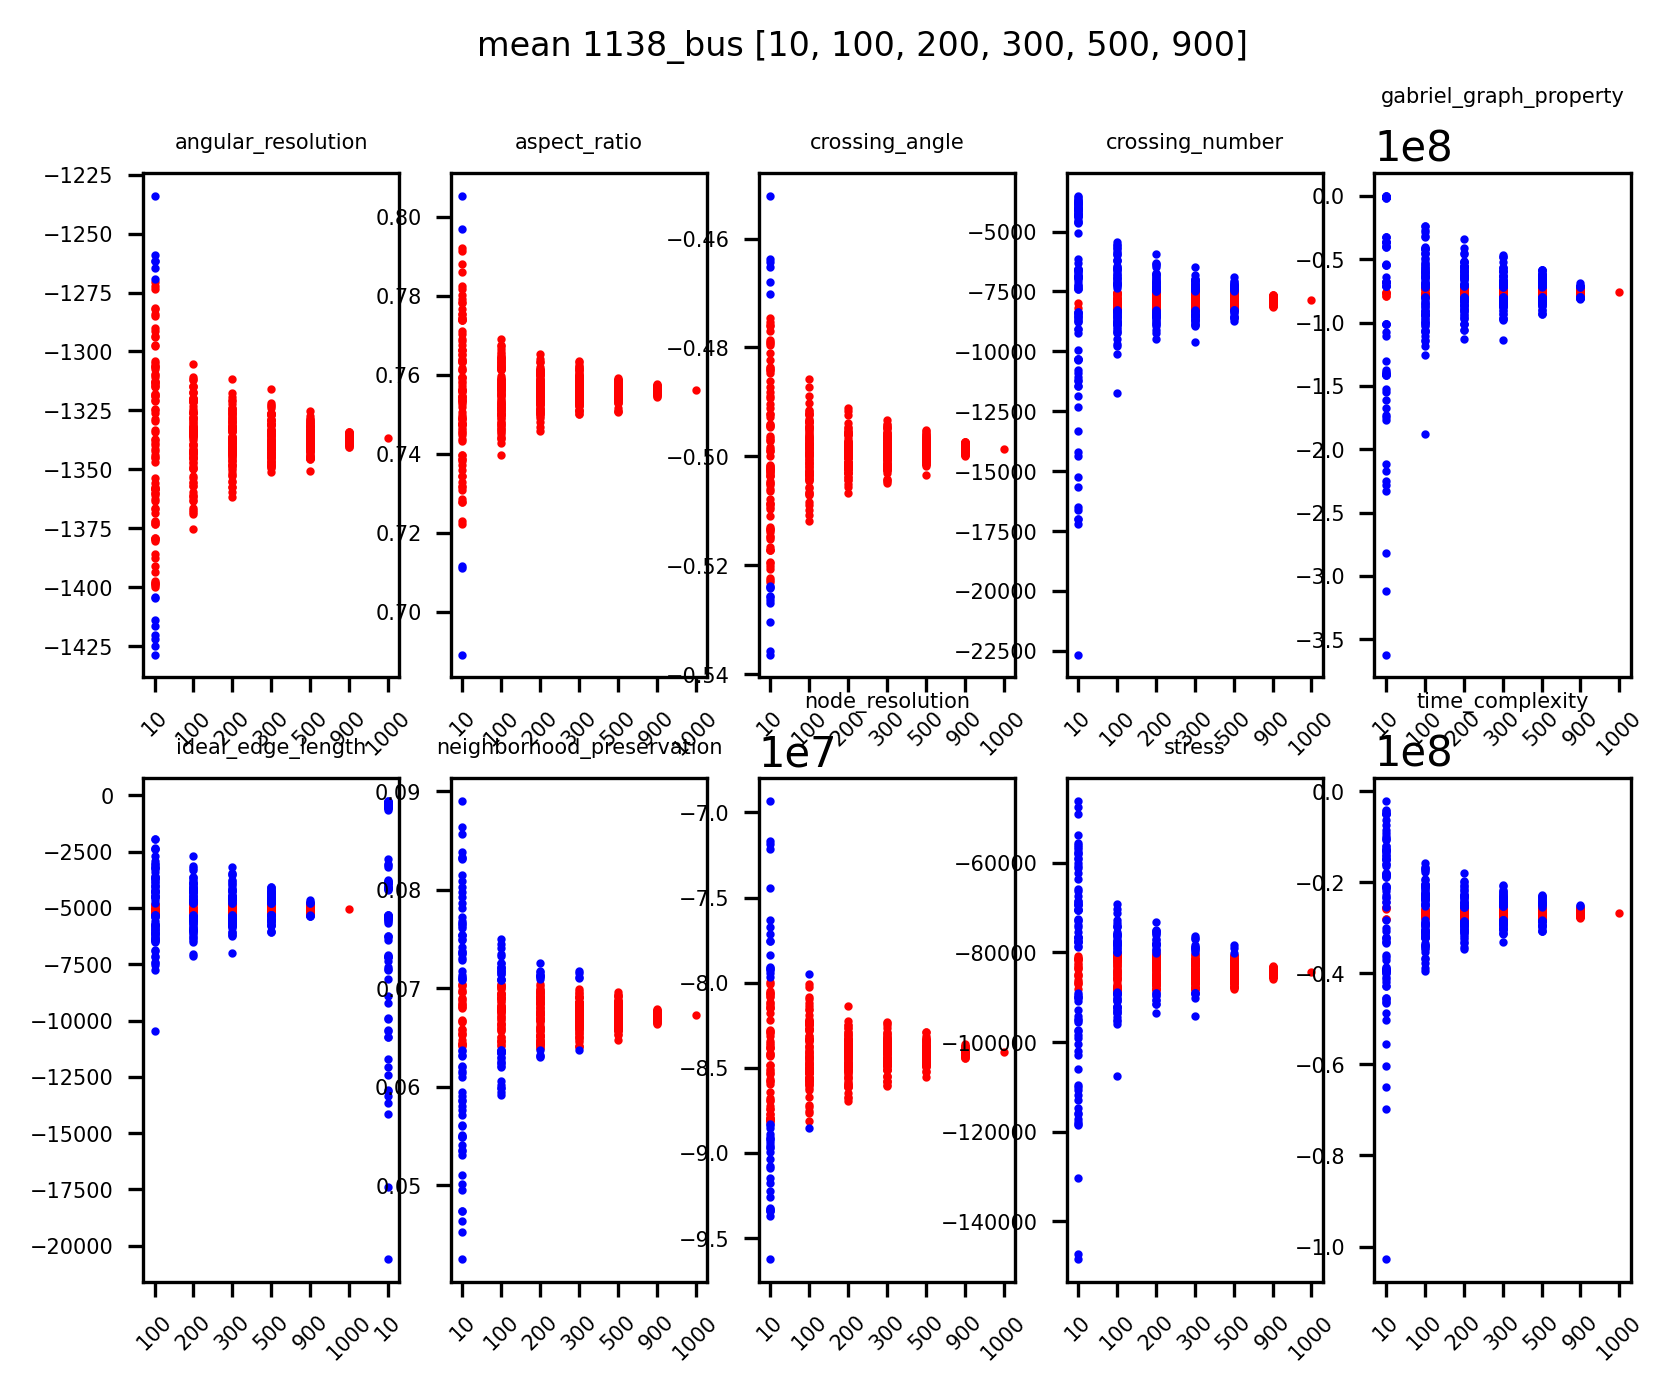

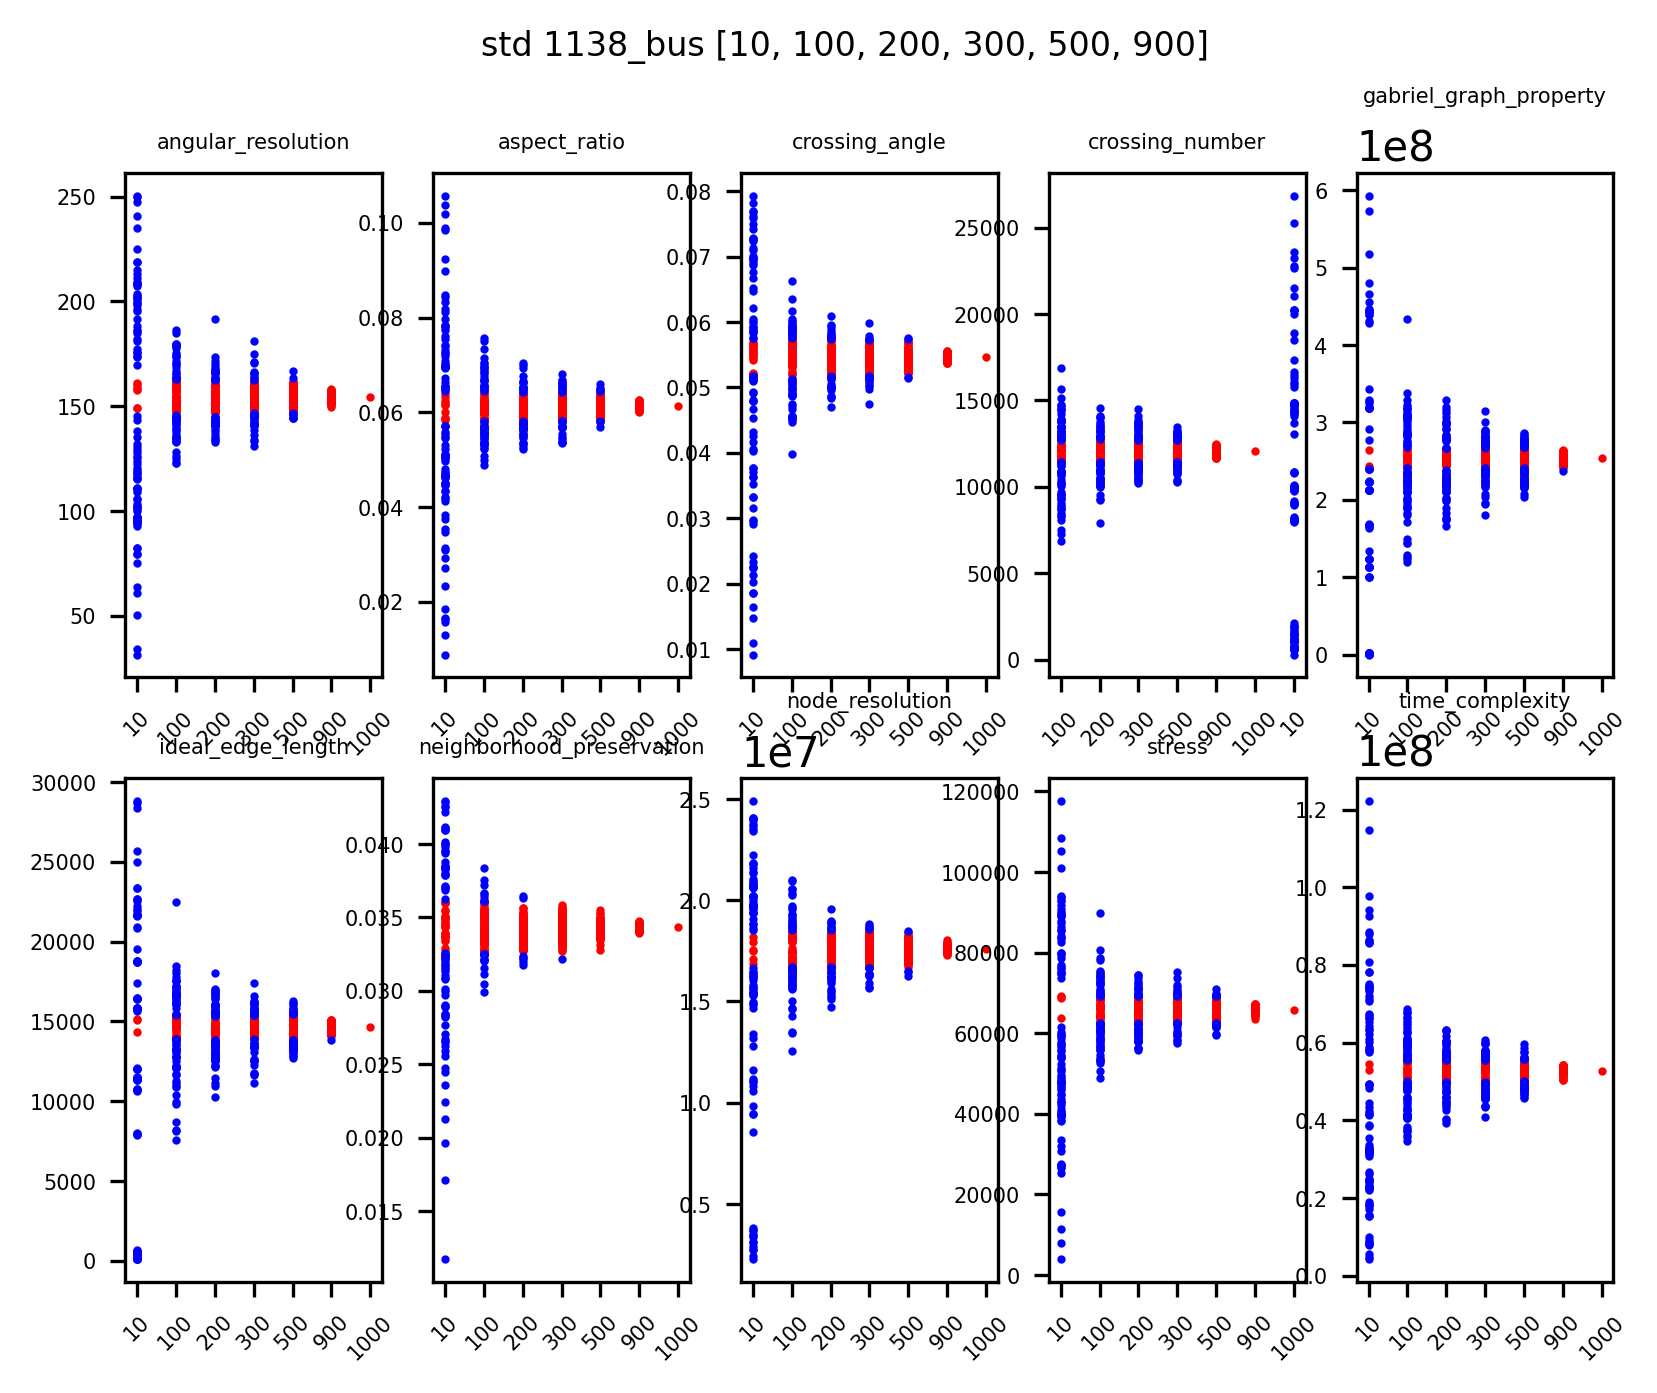

{'sample_size': 1000, 'mean_angular_resolution': -6741.901575195313, 'std_angular_resolution': 659.381350403125, 'mean_aspect_ratio': 0.8322907616198063, 'std_aspect_ratio': 0.05410985164037891, 'mean_crossing_angle': -0.529920214041073, 'std_crossing_angle': 0.07748390126923595, 'mean_crossing_number': -96459.185, 'std_crossing_number': 222011.97419040077, 'mean_gabriel_graph_property': -2130461824.91375, 'std_gabriel_graph_property': 8072193169.510509, 'mean_ideal_edge_length': -42361.65239135742, 'std_ideal_edge_length': 127512.34480080573, 'mean_neighborhood_preservation': 0.031846538979560135, 'std_neighborhood_preservation': 0.01743333031725248, 'mean_node_resolution': -7703524807.168, 'std_node_resolution': 1753243906.6798205, 'mean_stress': -1376135.19078125, 'std_stress': 1235968.2460938373, 'mean_time_complexity': -454945343.8589436, 'std_time_complexity': 992177800.4250947}


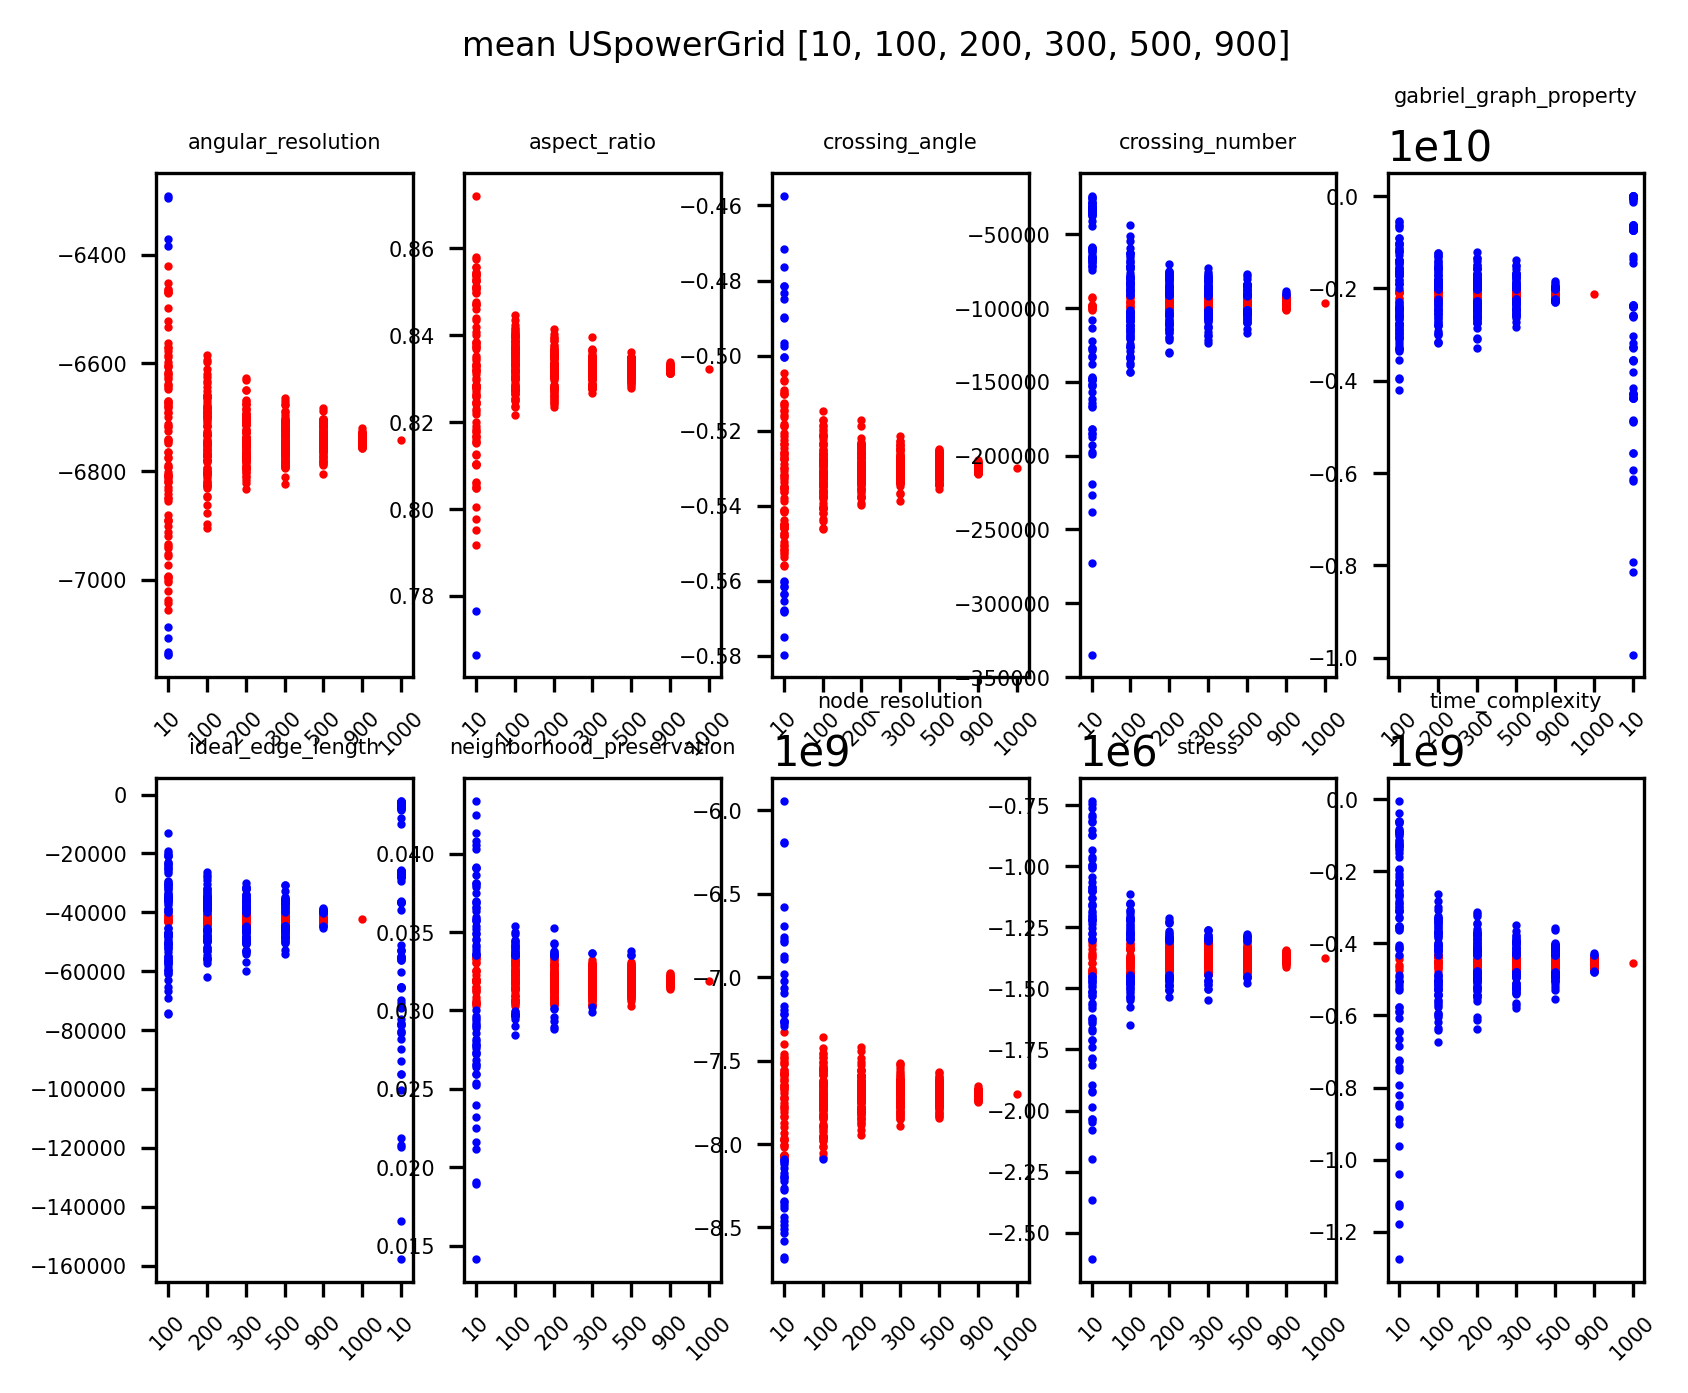

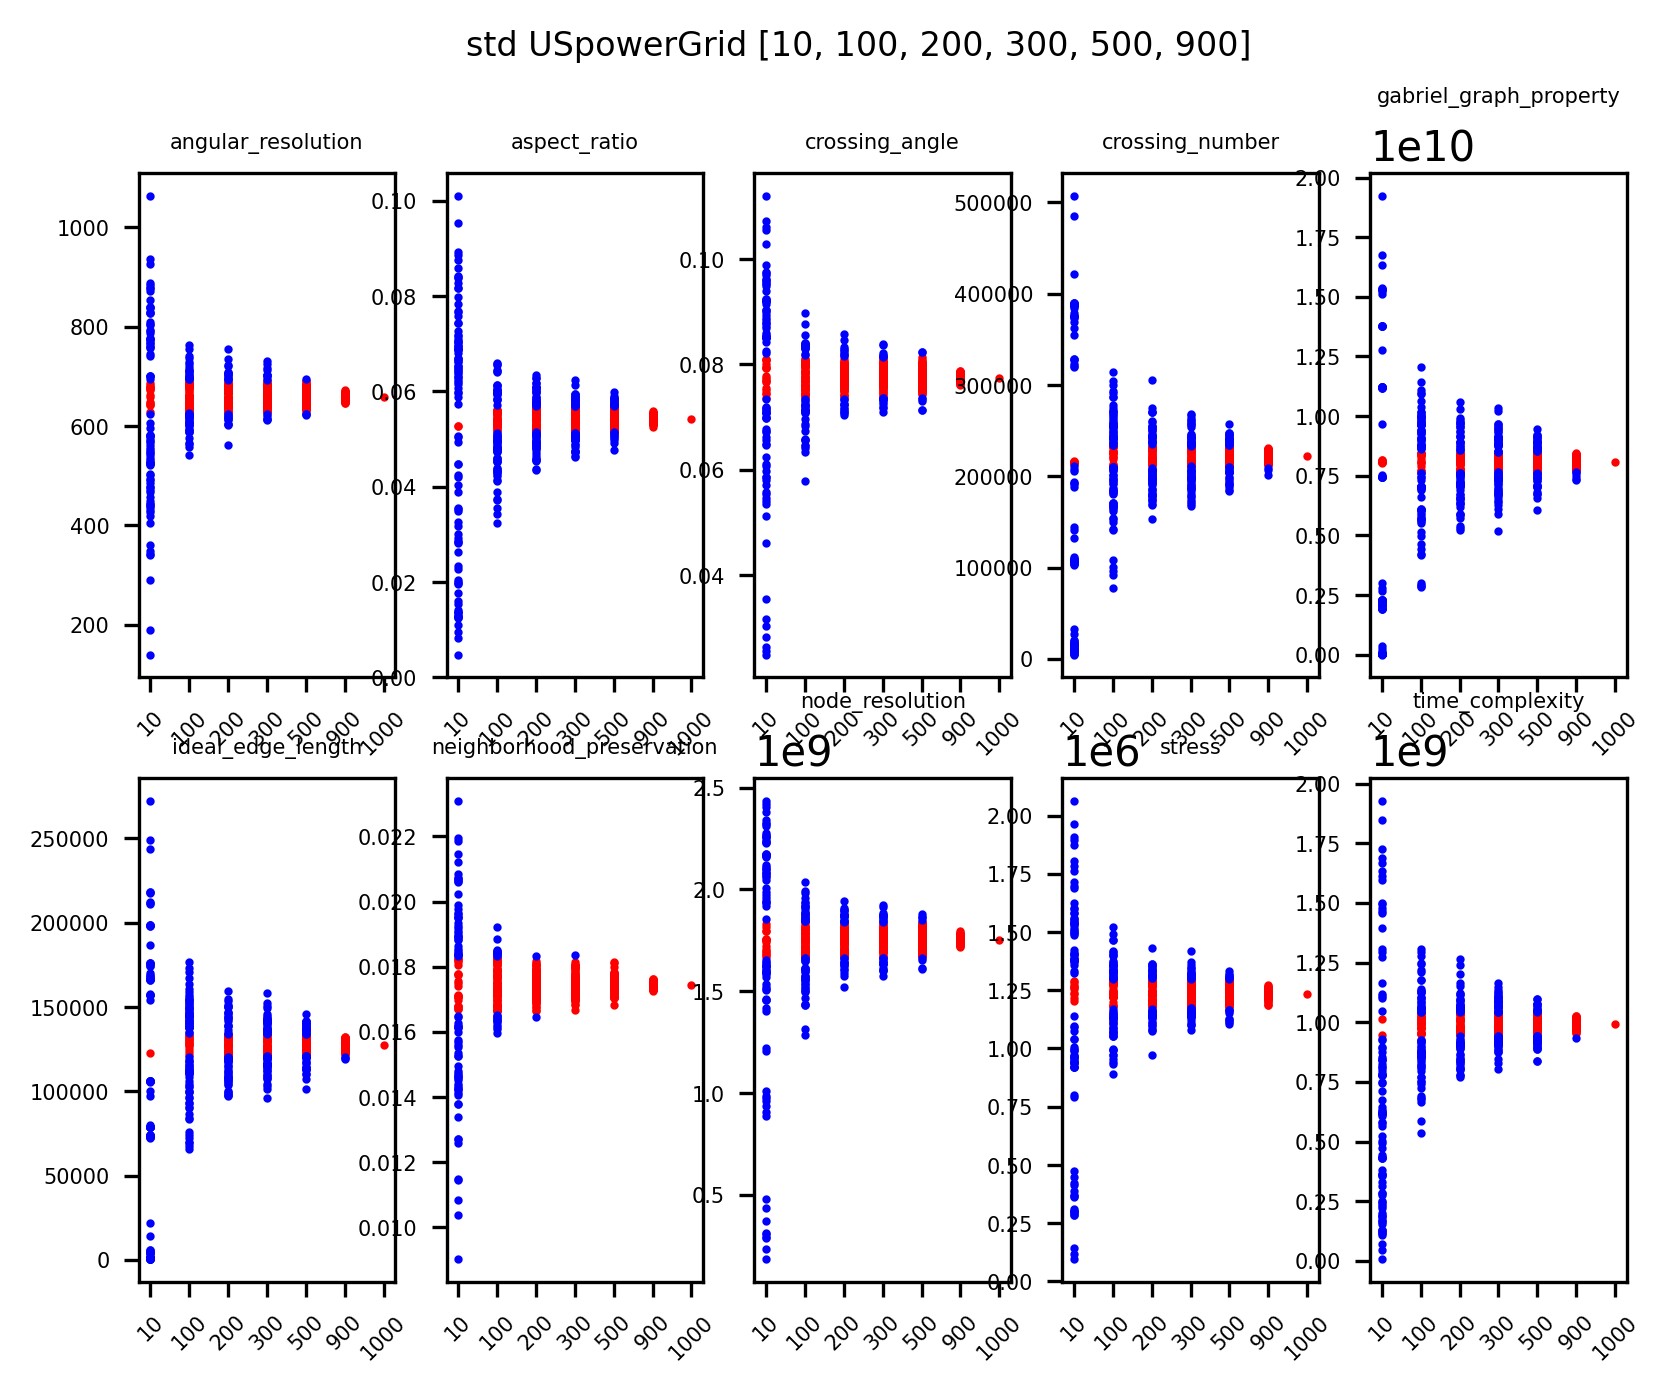

{'sample_size': 1000, 'mean_angular_resolution': -9320.329049316406, 'std_angular_resolution': 1240.1158846364442, 'mean_aspect_ratio': 0.8980551736503839, 'std_aspect_ratio': 0.15233086002978444, 'mean_crossing_angle': -0.43872809015263564, 'std_crossing_angle': 0.024405702646872682, 'mean_crossing_number': -39343.7575, 'std_crossing_number': 41913.15914109351, 'mean_gabriel_graph_property': -39694464.95059375, 'std_gabriel_graph_property': 188132537.12737423, 'mean_ideal_edge_length': -3697.346776939392, 'std_ideal_edge_length': 13610.845557648006, 'mean_neighborhood_preservation': 0.32509881822019815, 'std_neighborhood_preservation': 0.12340255130016993, 'mean_node_resolution': -73504180.546, 'std_node_resolution': 11927714.052442372, 'mean_stress': -40485.6018125, 'std_stress': 63961.53545675642, 'mean_time_complexity': -21882830.466310866, 'std_time_complexity': 41884535.422163405}


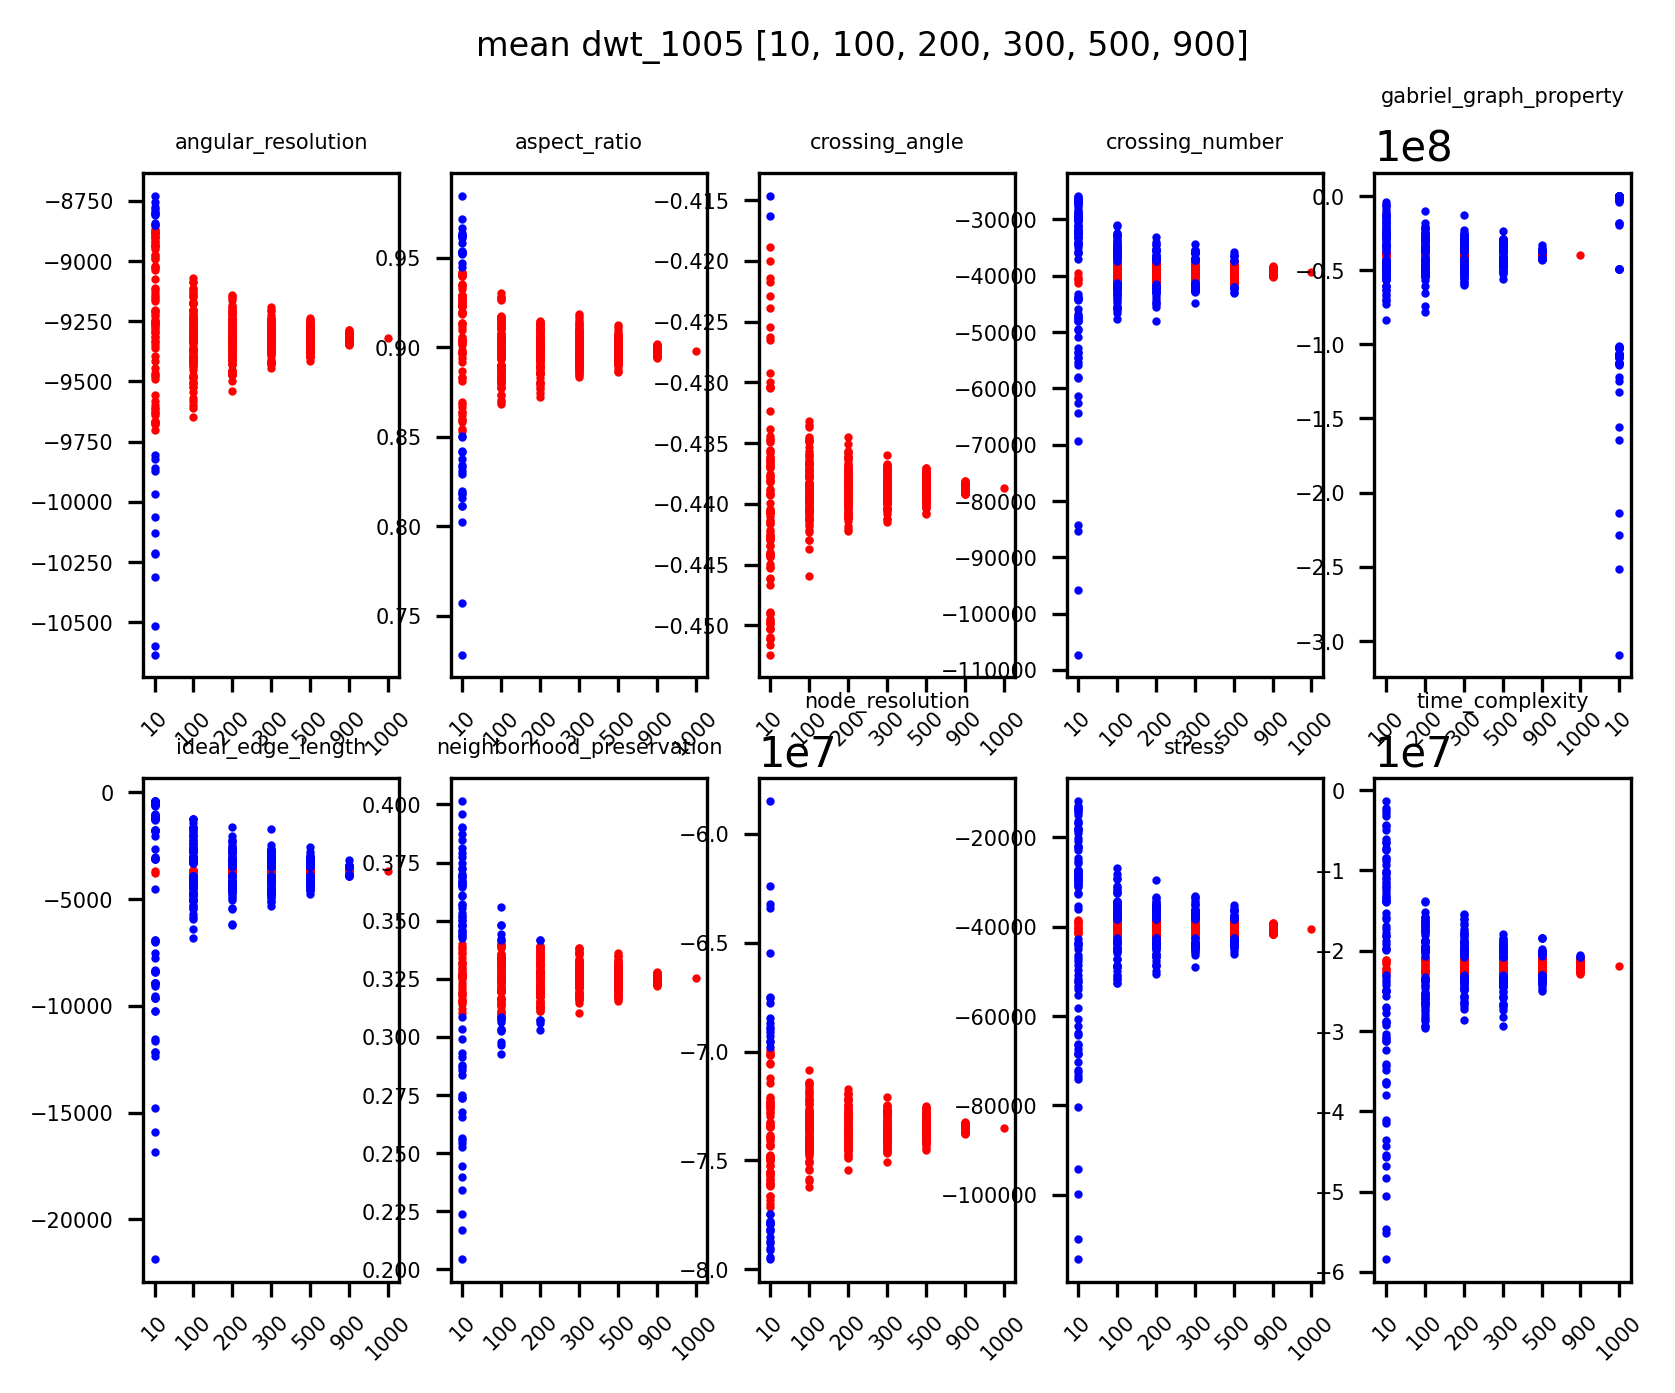

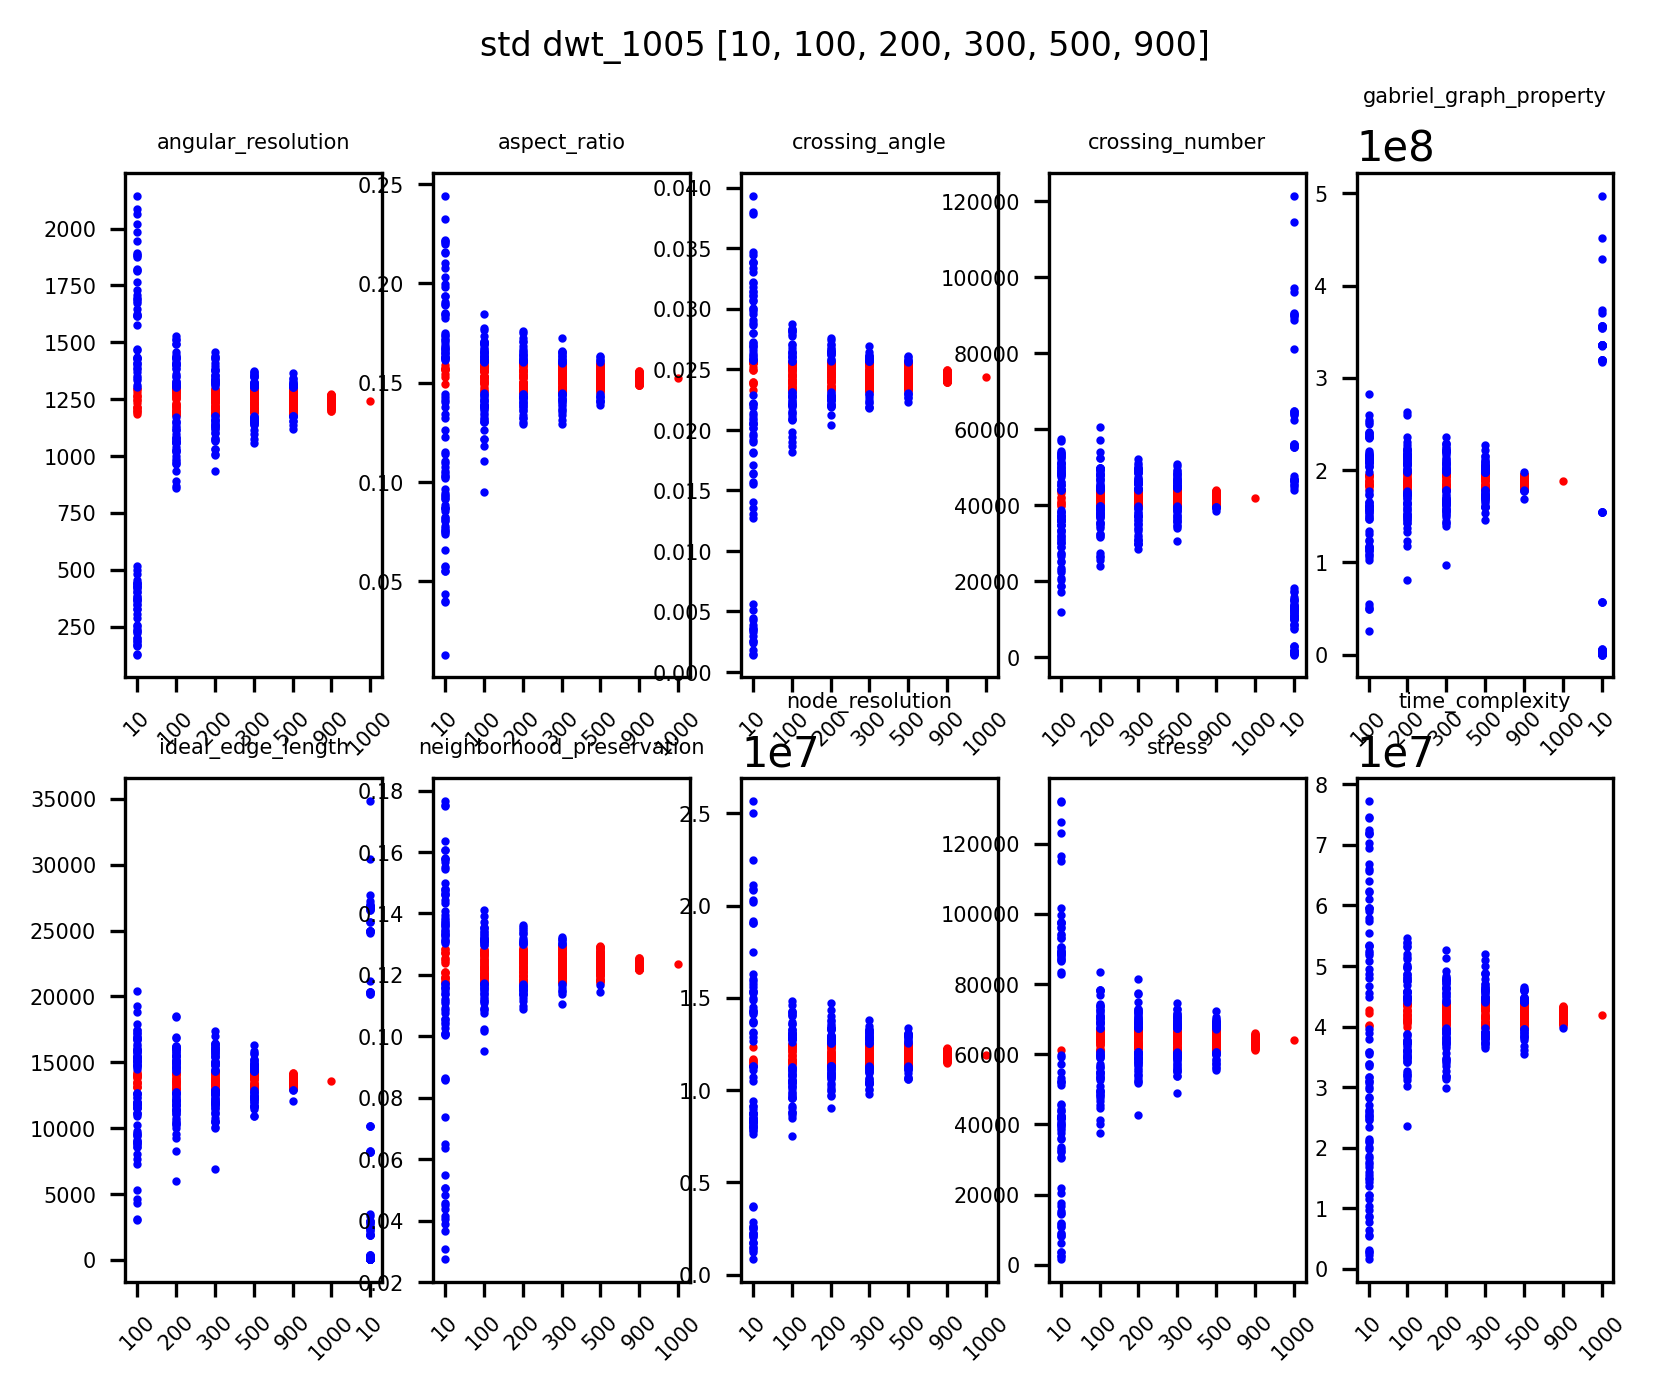

In [3]:
def generate_plot_data(df, sample_size):
    sampled_df = df.sample(n=sample_size)
    plot_data_obj = {}
    plot_data_obj["sample_size"] = sample_size
    for qm_name in qm_names:
        plot_data_obj[f"mean_{qm_name}"] = sampled_df[
            f"values_{qm_name}"
        ].mean()
        plot_data_obj[f"std_{qm_name}"] = sampled_df[f"values_{qm_name}"].std()

    return plot_data_obj


cmap = {True: "blue", False: "red"}

for d_name in ["les_miserables", "1138_bus", "USpowerGrid", "dwt_1005"]:
    n_trials = 100
    n_split = 10
    data_seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    df_paths = [
        ex_path.joinpath(
            f"data/grid/{d_name}/seed={data_seed}_n={n_split}.pkl"
        )
        for data_seed in data_seeds
    ]
    base_df = pd.concat(
        [pd.read_pickle(df_path) for df_path in df_paths]
    ).reset_index()

    median_df = generate_seed_median_df(base_df)

    plot_data = []
    # sample_sizes = [1, 10, 100, 200, 300, 400, 500, 1000]
    sample_sizes = [10, 100, 200, 300, 500, 900]
    for sample_size in sample_sizes:
        for trial_number in range(n_trials):
            plot_data_obj = generate_plot_data(median_df, sample_size)
            plot_data.append(plot_data_obj)
    full = generate_plot_data(median_df, 1000)
    plot_data.append(full)

    plot_df = pd.DataFrame(plot_data).sort_values("sample_size").reset_index()
    pv = 0.05
    print(full)

    fig, axes = plt.subplots(
        nrows=2, ncols=5, dpi=300, facecolor="white", squeeze=False
    )
    fig.suptitle(f"mean {d_name} {sample_sizes}", fontsize=8)
    for qm_name, ax in zip(qm_names, axes.flatten()):
        full_mean_qm = full[f"mean_{qm_name}"]
        mean_lower, mean_upper = full_mean_qm - (
            abs(full_mean_qm) * pv
        ), full_mean_qm + (abs(full_mean_qm) * pv)

        con = (mean_lower <= plot_df[f"mean_{qm_name}"]) & (
            plot_df[f"mean_{qm_name}"] <= mean_upper
        )
        mean_in_df = plot_df[con]
        mean_out_df = plot_df[~con]

        ax.tick_params(axis="x", labelrotation=45)
        ax.set_title(f"{qm_name}", fontsize=5)

        ax.scatter(
            list(map(str, mean_in_df["sample_size"].values)),
            mean_in_df[f"mean_{qm_name}"],
            s=1,
            color="red",
        )
        ax.scatter(
            list(map(str, mean_out_df["sample_size"].values)),
            mean_out_df[f"mean_{qm_name}"],
            s=1,
            color="blue",
        )
        ax.tick_params(axis="x", labelsize=5)
        ax.tick_params(axis="y", labelsize=5)
    plt.show()

    fig, axes = plt.subplots(
        nrows=2, ncols=5, dpi=300, facecolor="white", squeeze=False
    )
    fig.suptitle(f"std {d_name} {sample_sizes}", fontsize=8)
    for qm_name, ax in zip(qm_names, axes.flatten()):
        full_std_qm = full[f"std_{qm_name}"]
        std_lower, std_upper = full_std_qm - (
            abs(full_std_qm) * pv
        ), full_std_qm + (abs(full_std_qm) * pv)

        con = (std_lower <= plot_df[f"std_{qm_name}"]) & (
            plot_df[f"std_{qm_name}"] <= std_upper
        )
        std_in_df = plot_df[con]
        std_out_df = plot_df[~con]

        ax.tick_params(axis="x", labelrotation=45)
        ax.set_title(f"{qm_name}", fontsize=5)

        ax.scatter(
            list(map(str, std_in_df["sample_size"].values)),
            std_in_df[f"std_{qm_name}"],
            s=1,
            color="red",
        )
        ax.scatter(
            list(map(str, std_out_df["sample_size"].values)),
            std_out_df[f"std_{qm_name}"],
            s=1,
            color="blue",
        )
        ax.tick_params(axis="x", labelsize=5)
        ax.tick_params(axis="y", labelsize=5)
    plt.show()